<a href="https://colab.research.google.com/github/somyayadav14/Walmart-Sales-Forecasting/blob/main/Walmart_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score

Load Dataset

In [2]:
import pandas as pd
# train set
df_train = pd.read_csv('/content/train.csv.zip')
df_train

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [3]:
#store data
df_store = pd.read_csv('/content/train.csv.zip')
df_store

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [4]:
df_store.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [6]:
import pandas as pd
df_features = pd.read_csv('/content/stores.csv')
df_features.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


Merge the datasets

In [9]:
train_merged = pd.merge(df_train, df_features, on='Store')
# The original code attempted to merge with a 'features' dataframe on 'Store' and 'Date'.
# However, no dataframe named 'features' containing 'Date' was loaded.
# If you have a separate 'features.csv' with date-specific features, load it first.
# train_merged = pd.merge(train_merged, features, on=['Store', 'Date'])

# The 'test' dataframe is not defined, so the test data merging is commented out.
# You would typically load a 'test.csv' file here.
# test_merged = pd.merge(test, stores, on='Store')
# test_merged = pd.merge(test_merged, features, on=['Store', 'Date'])

display(train_merged.head())
# display(test_merged.head()) # Commented out as test_merged is not defined

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315


Data preprocessing


In [11]:
# Identify and handle missing values
# Load test data and merge to create test_merged (as it was not defined previously)
import pandas as pd # Ensure pandas is available
df_test = pd.read_csv('/content/test.csv.zip') # Assuming test data is in this path
test_merged = pd.merge(df_test, df_features, on='Store')

train_merged.fillna(method='ffill', inplace=True)
test_merged.fillna(method='ffill', inplace=True)

# Convert 'Date' column to datetime objects
train_merged['Date'] = pd.to_datetime(train_merged['Date'])
test_merged['Date'] = pd.to_datetime(test_merged['Date'])

# Create time-based features
train_merged['Year'] = train_merged['Date'].dt.year
train_merged['Month'] = train_merged['Date'].dt.month
train_merged['DayOfWeek'] = train_merged['Date'].dt.dayofweek

test_merged['Year'] = test_merged['Date'].dt.year
test_merged['Month'] = test_merged['Date'].dt.month
test_merged['DayOfWeek'] = test_merged['Date'].dt.dayofweek

display(train_merged.head())
display(test_merged.head())

FileNotFoundError: [Errno 2] No such file or directory: '/content/test.csv.zip'

Feature Engineering

In [ ]:
train_merged['WeekOfYear'] = train_merged['Date'].dt.isocalendar().week.astype(int)
test_merged['WeekOfYear'] = test_merged['Date'].dt.isocalendar().week.astype(int)

train_merged['Weekly_Sales_Lag1'] = train_merged.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
train_merged['Weekly_Sales_Lag2'] = train_merged.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(2)
train_merged['Weekly_Sales_Lag4'] = train_merged.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(4)

train_merged.fillna(method='ffill', inplace=True)

display(train_merged.head())
display(test_merged.head())

/tmp/ipython-input-3416171569.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_merged.fillna(method='ffill', inplace=True)


,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,...,CPI,Unemployment,IsHoliday_y,Year,Month,DayOfWeek,WeekOfYear,Weekly_Sales_Lag1,Weekly_Sales_Lag2,Weekly_Sales_Lag4
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,...,211.096358,8.106,False,2010,2,4,5,NaN,NaN,NaN
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,...,211.242170,8.106,True,2010,2,4,6,24924.50,NaN,NaN
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,...,211.289143,8.106,False,2010,2,4,7,46039.49,24924.50,NaN
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,...,211.319643,8.106,False,2010,2,4,8,41595.55,46039.49,NaN
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,...,211.350143,8.106,False,2010,3,4,9,19403.54,41595.55,24924.5


,Store,Dept,Date,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Year,Month,DayOfWeek,WeekOfYear
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,False,2012,11,4,44
1,1,1,2012-11-09,False,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,False,2012,11,4,45
2,1,1,2012-11-16,False,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,False,2012,11,4,46
3,1,1,2012-11-23,True,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,True,2012,11,4,47
4,1,1,2012-11-30,False,A,151315,52.34,3.207,2460.03,4.17,3838.35,150.57,6966.34,223.610984,6.573,False,2012,11,4,48


Exploratory Analysis

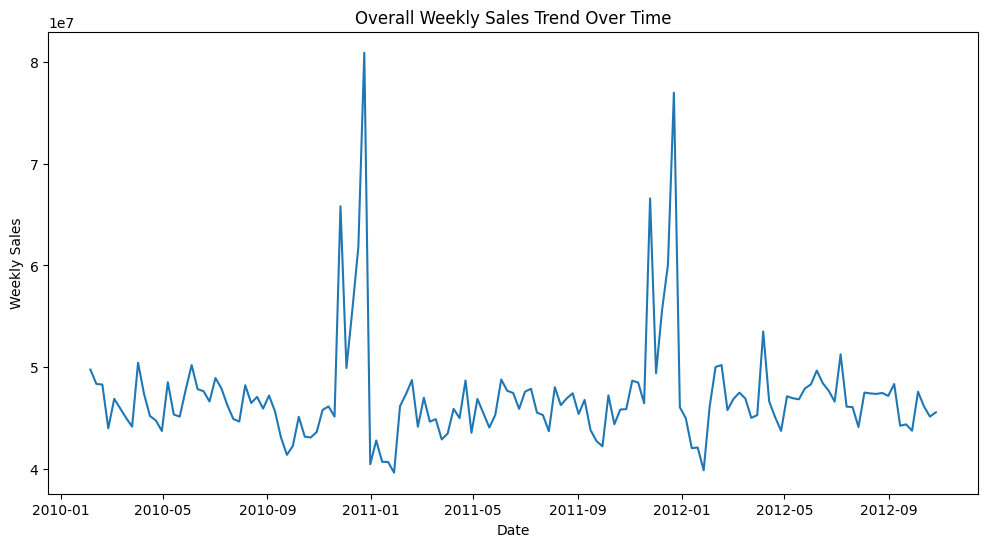

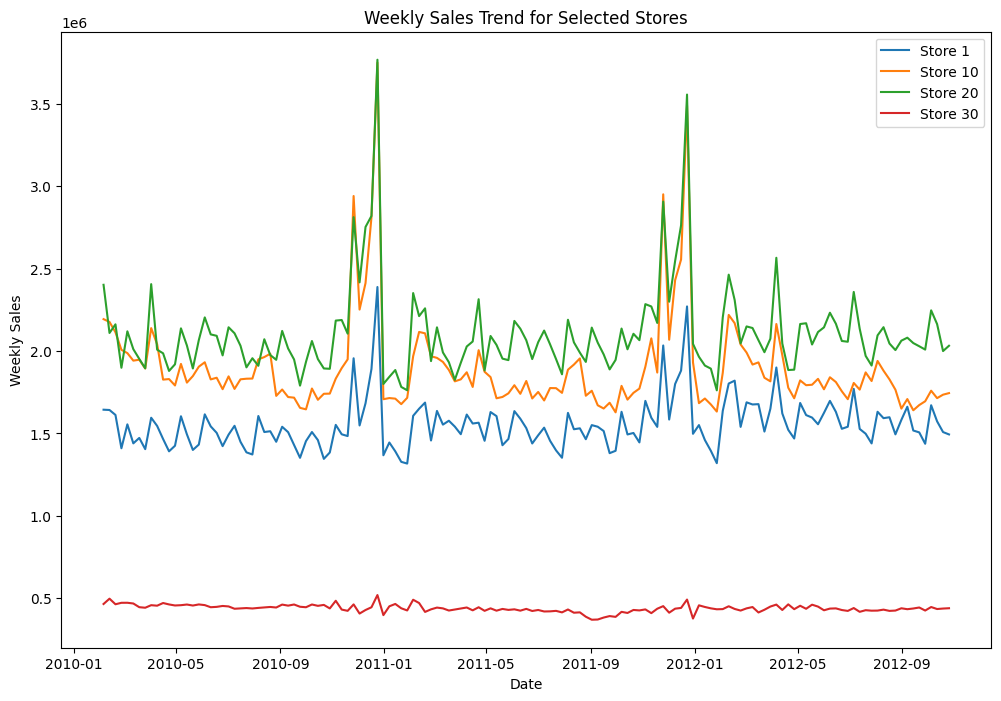

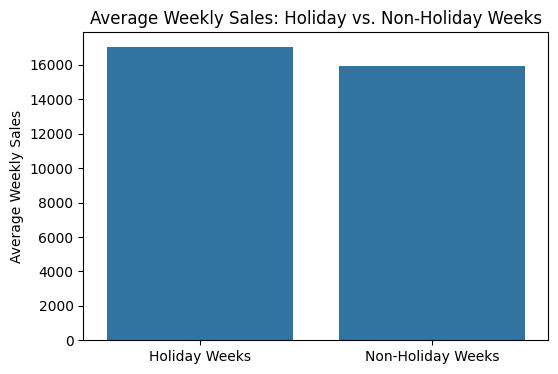

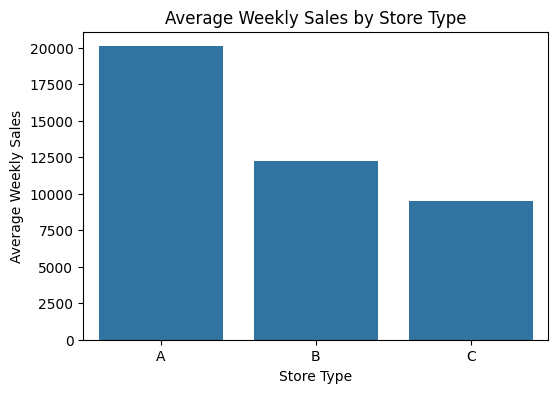

In [ ]:
# 1. Overall weekly sales trend
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Weekly_Sales', data=train_merged.groupby('Date')['Weekly_Sales'].sum().reset_index())
plt.title('Overall Weekly Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

# 2. Weekly sales for a few individual stores
selected_stores = [1, 10, 20, 30]
plt.figure(figsize=(12, 8))
for store in selected_stores:
    store_data = train_merged[train_merged['Store'] == store].groupby('Date')['Weekly_Sales'].sum().reset_index()
    sns.lineplot(x='Date', y='Weekly_Sales', data=store_data, label=f'Store {store}')
plt.title('Weekly Sales Trend for Selected Stores')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

# 3. Impact of holidays on weekly sales
holiday_sales = train_merged[train_merged['IsHoliday_x'] == True]['Weekly_Sales'].mean()
non_holiday_sales = train_merged[train_merged['IsHoliday_x'] == False]['Weekly_Sales'].mean()

plt.figure(figsize=(6, 4))
sns.barplot(x=['Holiday Weeks', 'Non-Holiday Weeks'], y=[holiday_sales, non_holiday_sales])
plt.title('Average Weekly Sales: Holiday vs. Non-Holiday Weeks')
plt.ylabel('Average Weekly Sales')
plt.show()

# 4. Average weekly sales by store type
avg_sales_by_type = train_merged.groupby('Type')['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x='Type', y='Weekly_Sales', data=avg_sales_by_type)
plt.title('Average Weekly Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Weekly Sales')
plt.show()

In [ ]:
target = 'Weekly_Sales'

X = train_merged.drop(columns=[target, 'Date'])
y = train_merged[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = pd.get_dummies(X_train, columns=['Type'], drop_first=True)
X_val = pd.get_dummies(X_val, columns=['Type'], drop_first=True)

X_train.fillna(0, inplace=True)
X_val.fillna(0, inplace=True)

print("Missing values in X_train:", X_train.isnull().sum().sum())

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

lgb_model = lgb.LGBMRegressor(objective='regression', n_estimators=100, learning_rate=0.1, random_state=42)
lgb_model.fit(X_train, y_train)

print("All models trained successfully!")

Missing values in X_train: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 337256, number of used features: 22
[LightGBM] [Info] Start training from score 15979.221909
All models trained successfully!


In [ ]:
# Make predictions on the training data
lr_predictions = lr_model.predict(X_train)
xgb_predictions = xgb_model.predict(X_train)
lgb_predictions = lgb_model.predict(X_train)

# Calculate Mean Squared Error (MSE) for each model
lr_mse = mean_squared_error(y_train, lr_predictions)
xgb_mse = mean_squared_error(y_train, xgb_predictions)
lgb_mse = mean_squared_error(y_train, lgb_predictions)

# Calculate R-squared score for each model
lr_r2 = r2_score(y_train, lr_predictions)
xgb_r2 = r2_score(y_train, xgb_predictions)
lgb_r2 = r2_score(y_train, lgb_predictions)

# Print the evaluation metrics
print(f"Linear Regression - MSE: {lr_mse:.2f}, R-squared: {lr_r2:.2f}")
print(f"XGBoost - MSE: {xgb_mse:.2f}, R-squared: {xgb_r2:.2f}")
print(f"LightGBM - MSE: {lgb_mse:.2f}, R-squared: {lgb_r2:.2f}")

Linear Regression - MSE: 44167312.47, R-squared: 0.91
XGBoost - MSE: 16444663.68, R-squared: 0.97
LightGBM - MSE: 15032283.25, R-squared: 0.97


Predict Data

In [ ]:
# Ensure test data has the same columns as training data
test_processed = test_merged.copy()

# Handle missing values in test_processed using the same strategy (fill with 0)
test_processed.fillna(0, inplace=True)

# One-hot encode categorical features in test_processed to match X_train
test_processed = pd.get_dummies(test_processed, columns=['Store', 'Dept', 'Type', 'IsHoliday_x'], drop_first=True)

# Align columns - add missing columns from X_train and fill with 0
missing_cols = set(X_train.columns) - set(test_processed.columns)
for c in missing_cols:
    test_processed[c] = 0

# Ensure the order of columns is the same as in X_train
test_processed = test_processed[X_train.columns]

# Make predictions using the trained models
lr_test_predictions = lr_model.predict(test_processed)
xgb_test_predictions = xgb_model.predict(test_processed)
lgb_test_predictions = lgb_model.predict(test_processed)

print("Predictions made successfully.")

Predictions made successfully.


In [ ]:
# Create a DataFrame for plotting predictions
predictions_df = test_merged[['Date', 'Store', 'Dept']].copy()

# Add predictions from each model
predictions_df['Weekly_Sales_LR'] = lr_test_predictions
predictions_df['Weekly_Sales_XGB'] = xgb_test_predictions
predictions_df['Weekly_Sales_LGB'] = lgb_test_predictions

# Select a specific store and department for visualization
selected_store = 1
selected_dept = 1

# Filter the predictions DataFrame for the selected store and department
filtered_predictions_df = predictions_df[(predictions_df['Store'] == selected_store) & (predictions_df['Dept'] == selected_dept)].copy()

display(filtered_predictions_df.head())

,Date,Store,Dept,Weekly_Sales_LR,Weekly_Sales_XGB,Weekly_Sales_LGB
0,2012-11-02,1,1,672.362208,13692.841797,6269.945923
1,2012-11-09,1,1,677.770806,13013.735352,697.689172
2,2012-11-16,1,1,746.481413,13479.010742,7360.467933
3,2012-11-23,1,1,6454.192417,12928.782227,5291.363104
4,2012-11-30,1,1,619.756111,14023.615234,7275.582100


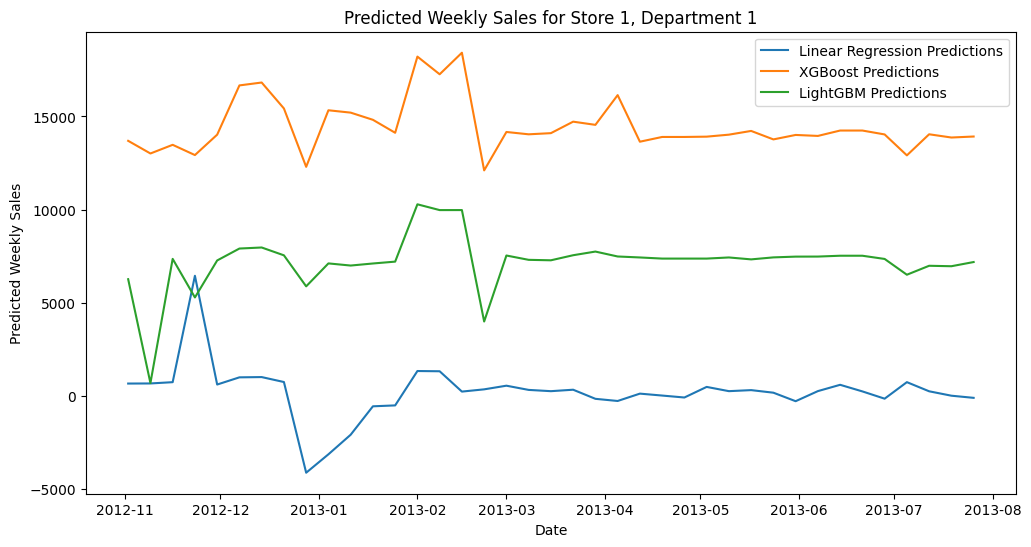

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Weekly_Sales_LR', data=filtered_predictions_df, label='Linear Regression Predictions')
sns.lineplot(x='Date', y='Weekly_Sales_XGB', data=filtered_predictions_df, label='XGBoost Predictions')
sns.lineplot(x='Date', y='Weekly_Sales_LGB', data=filtered_predictions_df, label='LightGBM Predictions')
plt.title(f'Predicted Weekly Sales for Store {selected_store}, Department {selected_dept}')
plt.xlabel('Date')
plt.ylabel('Predicted Weekly Sales')
plt.legend()
plt.show()